## 1. Loading data

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc.stop()
sc = SparkContext('local')
spark = SparkSession(sc)

#sc = SparkContext()  # if using locally
#sql_sc = SQLContext(sc)
adult_df = spark.read.option("inferSchema","true").csv('gs://bigdata-chu/hw1/adult.csv').toDF(
 "age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income")


## 2. data processing 
- Convert the categorical variables into numeric variables
- Split your data into training set and test setwith ratio of 70% and 30% and set the seed to 100

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [3]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]

In [4]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
##extract all the numeric columns into a matrix as features
##extract income as labels

In [5]:
from pyspark.ml.classification import LogisticRegression
  
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(adult_df)
preppedDataDF = pipelineModel.transform(adult_df)

In [6]:
from pyspark.ml.classification import LogisticRegression

# Keep relevant columns
selectedcols = ["label", "features"] + categoricalColumns + numericCols
adult_df2 = preppedDataDF.select(selectedcols)
### Randomly split data into training and test sets. set seed for reproducibility
(training, test) = adult_df2.randomSplit([0.7, 0.3], seed=100)
print(training.count())
print(test.count())

22838
9723


## 3. Modeling
- train a loggistic regression model
- plot ROC curve and Precision-Recall curve 

In [7]:

from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
lrModel = lr.fit(training)

In [8]:
# ROC for training data
modelsummary = lrModel.summary

In [9]:
df_FPR = modelsummary.roc.select('FPR')
df_FPR.sql_ctx.sparkSession = spark._jsparkSession
df_FPR._sc = spark._sc
FPR = df_FPR.collect()

df_TPR = modelsummary.roc.select('TPR')
df_TPR.sql_ctx.sparkSession = spark._jsparkSession
df_TPR._sc = spark._sc
TPR = df_TPR.collect()

In [10]:
import matplotlib.pyplot as plt
plt.plot(FPR,TPR)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC of the logistic regression')
plt.show()

In [11]:
modelsummary.pr.show(5)

+--------------------+------------------+
|              recall|         precision|
+--------------------+------------------+
|                 0.0|0.9912280701754386|
|0.041346505671423346|0.9912280701754386|
| 0.08177826564215149|0.9802631578947368|
| 0.12001463593121112|0.9590643274853801|
| 0.15642151481888036|            0.9375|
+--------------------+------------------+
only showing top 5 rows



In [12]:
df_re = modelsummary.pr.select('recall')
df_re.sql_ctx.sparkSession = spark._jsparkSession
df_re._sc = spark._sc
re = df_re.collect()

df_pr = modelsummary.pr.select('precision')
df_pr.sql_ctx.sparkSession = spark._jsparkSession
df_pr._sc = spark._sc
pr = df_pr.collect()

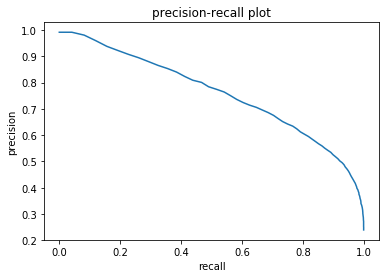

In [13]:
plt.plot(re,pr)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision-recall plot')
plt.show()

#type(roc['FPR'])

In [14]:
#type(roc['FPR'])

### 4.Evaluation
- Apply your trained model on the test set
- Provide the value of area under ROC,accuracy, and confusion matrix. 

In [15]:
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(test)

# View model's predictions and probabilities of each prediction class
# You can select any columns in the above schema to view as well. For example's sake we will choose age & occupation
selected = predictions.select("label", "prediction", "probability", "age", "occupation")
display(selected)

DataFrame[label: double, prediction: double, probability: vector, age: int, occupation: string]

In [16]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)
##From the result we can know areunderROC = 0.9014  

0.9014206228690932

In [17]:
actual = selected.select('label').toPandas()
predicted = selected.select('prediction').toPandas()

In [18]:
selected.crosstab('label', 'prediction').show()

+----------------+----+----+
|label_prediction| 0.0| 1.0|
+----------------+----+----+
|             1.0| 964|1411|
|             0.0|6847| 501|
+----------------+----+----+



In [19]:
from sklearn import metrics
metrics.accuracy_score(actual, predicted)

##acurracy score is 0.849

0.8493263396071171